## Preparing

### Import

In [1]:
import csv

import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier    
from sklearn.metrics import accuracy_score

import pydotplus

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [4]:
import csv
with open('raw_input.csv', 'r') as infile:
  with open('input.csv', 'w') as outfile:
    reader = csv.reader(infile)
    writer = csv.writer(outfile)
    for row in reader:
        if isinstance(row[1], str):
          writer.writerow(row)
          continue

        if int(row[1]) < 70:
          row[1] = 'cold'
        elif int(row[1]) >= 80:
          row[1] = 'hot'
        else:
          row[1] = 'mild'

        if int(row[2]) > 80:
          row[2] = 'high'
        else:
          row[2] = 'normal'
        writer.writerow(row)

df=pd.read_csv("input.csv")
df

,outlook,temprature,humidity,windy,play
0,sunny,85,85,False,no
1,sunny,80,90,True,no
2,overcast,83,86,False,yes
3,rain,70,96,False,yes
4,rain,68,80,False,yes
5,rain,65,70,True,no
6,overcast,64,65,True,yes
7,sunny,72,95,False,no
8,sunny,69,70,False,yes
9,rain,75,80,False,yes


In [5]:
#encoding
string_to_int= preprocessing.LabelEncoder()                    
df=df.apply(string_to_int.fit_transform)
df

,outlook,temprature,humidity,windy,play
0,2,11,4,0,0
1,2,8,6,1,0
2,0,10,5,0,1
3,1,4,9,0,1
4,1,2,3,0,1
5,1,1,1,1,0
6,0,0,0,1,1
7,2,6,8,0,0
8,2,3,1,0,1
9,1,7,3,0,1


In [6]:
feature_cols=['outlook','temprature','humidity','windy']
X = df[feature_cols ]                             
y = df.play

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Gini Index

In [9]:
gini_classifier =DecisionTreeClassifier(criterion="entropy", random_state=42)   
gini_classifier.fit(X_train, y_train)                                            
y_pred= gini_classifier.predict(X_test)

In [10]:
print("Accuracy gini_classifier:",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))  

Accuracy gini_classifier: 0.3333333333333333
[[0 1]
 [1 1]]


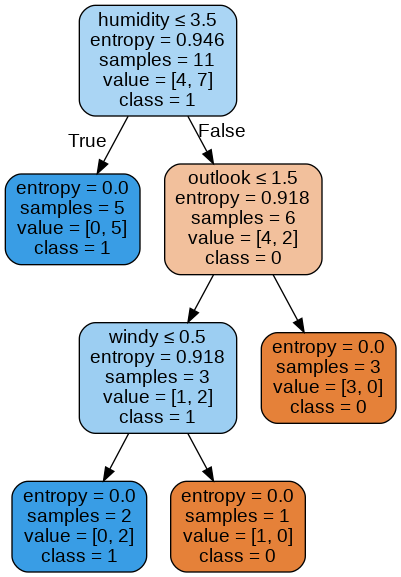

In [11]:
dot_data = StringIO()
export_graphviz(gini_classifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
gin_graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
gin_graph.write_png('gin.png')
Image(gin_graph.create_png())

## information gain

In [12]:
entropy_classifier =DecisionTreeClassifier(criterion="entropy",  random_state=42) 
entropy_classifier.fit(X_train, y_train)                                            
y_pred= entropy_classifier.predict(X_test)

In [13]:
from sklearn.metrics import accuracy_score
print("Accuracy entropy_classifier:",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))  

Accuracy entropy_classifier: 0.3333333333333333
[[0 1]
 [1 1]]


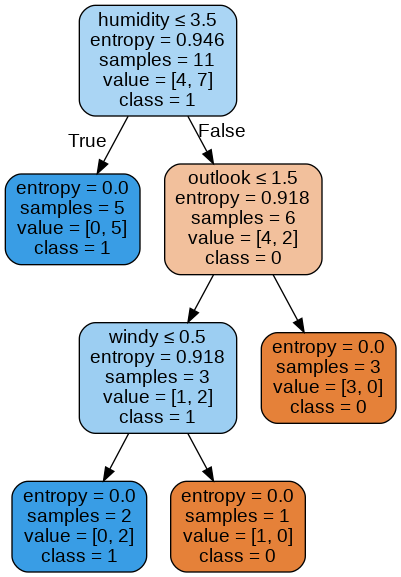

In [14]:
dot_data = StringIO()
export_graphviz(entropy_classifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
entropy_graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
entropy_graph.write_png('entropy.png')
Image(entropy_graph.create_png())

## Compare the result

The accuracy for different selection criteria is not much different, because of the sample size is too small in term of both train and test files

## Implements the Information gain from scratch

$$Entropy=-\sum_{i}^{n}p_ilog_{2}(p_i)$$

In [122]:
def entropy(counts, n_samples):
    return np.sum([-(ni/n_samples)*np.log2(ni/n_samples) for ni in counts])

$$ Gain(A)=Entrophy(D)-Entrophy_{A}(D)$$

In [123]:
def entropy_of_one_division(division): 
    n_samples = len(division)
    n_classes = set(division)
    counts=[]
    #count samples in each class then store it to list counts
    #TODO:
    for class_ in n_classes:
        counts.append(np.sum(np.array(division) == class_))
    
    return entropy(counts,n_samples),n_samples


def get_entropy(y_predict, y):
    n = len(y)
    entropy_true, n_true = entropy_of_one_division(y[y_predict]) # left hand side entropy
    entropy_false, n_false = entropy_of_one_division(y[~y_predict]) # right hand side entropy
    # overall entropy
    #TODO s=?
    s = (n_true/n)*entropy_true + (n_false/n)*entropy_false
    return s

## Decision Tree

In [124]:
class DecisionTreeClassifier:
    def __init__(self, tree=None, depth=0):
        '''Parameters:
        -----------------
        tree: decision tree
        depth: depth of decision tree after training'''
        
        self.depth = depth
        self.tree=tree
        
    def fit(self, X, y, node={}, depth=0):
        #Stop conditions
        
        #if all value of y are the same 
        if np.all(y==y[0]):
            return {'val':y[0]}

        else: 
            col_idx, cutoff, entropy = self.find_best_split_of_all(X, y)    # find one split given an information gain 
            y_left = y[X[:, col_idx] < cutoff]
            y_right = y[X[:, col_idx] >= cutoff]
            node = {'index_col':col_idx,
                        'cutoff':cutoff,
                   'val':np.mean(y)}
            node['left'] = self.fit(X[X[:, col_idx] < cutoff], y_left, {}, depth+1)
            node['right'] = self.fit(X[X[:, col_idx] >= cutoff], y_right, {}, depth+1)
            self.depth += 1 
            self.tree = node
            return node
    
    def find_best_split_of_all(self, X, y):
        col_idx = None
        min_entropy = 1
        cutoff = None
        for i, col_data in enumerate(X.T):
            entropy, cur_cutoff = self.find_best_split(col_data, y)
            if entropy == 0:                   #best entropy
                return i, cur_cutoff, entropy
            elif entropy <= min_entropy:
                min_entropy = entropy
                col_idx = i
                cutoff = cur_cutoff
            
        return col_idx, cutoff, min_entropy
    
    def find_best_split(self, col_data, y):
        ''' Parameters:
        -------------
        col_data: data samples in column'''
         
        min_entropy = 10

        #Loop through col_data find cutoff where entropy is minimum
        
        for value in set(col_data):
            y_predict = col_data < value
            my_entropy = get_entropy(y_predict, y)
            #TODO
            #min entropy=?, cutoff=?
            if my_entropy < min_entropy:
                min_entropy = my_entropy
                cutoff = value
      
        return min_entropy, cutoff
                                               
    def predict(self, X):
        tree = self.tree
        pred = np.zeros(shape=len(X))
        for i, c in enumerate(X):
            pred[i] = self._predict(c)
        return pred
    
    def _predict(self, row):
        cur_layer = self.tree
        while cur_layer.get('cutoff'):
            if row[cur_layer['index_col']] < cur_layer['cutoff']:
                cur_layer = cur_layer['left']
            else:
                cur_layer = cur_layer['right']
        else:
            return cur_layer.get('val')

In [138]:
model = DecisionTreeClassifier()
tree = model.fit(X_train.values, y_train.values)
pred=model.predict(X_train.values)
print('Accuracy of your decision tree model on training data:', accuracy_score(y_train,pred))
pred=model.predict(X_test.values)
print('Accuracy of your decision tree model:', accuracy_score(y_test,pred))

Accuracy of your decision tree model on training data: 1.0
Accuracy of your decision tree model: 0.3333333333333333
